In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
import pylab
from datetime import datetime
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.copula_model import *
from src.signal_generation import *
from src.backtesting import *
from src.pair_selection import *

from src.config import PROCESSED_DIR, BACKTEST_DIR

from pathlib import Path
os.chdir("/Users/emmanueladeleye/Documents/Quants Projects/Statistical Arbitrage/Pairs-Trading-Statistical-Arbitrage")
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

In [25]:
years = [2022, 2023, 2024, 2025]
methods = {
    'Pure Z-Score': False,
    'Z+Copula Veto': True
}
portfolio_data = {}
metrics_data = {}

for year in years:
    for method_name, use_copula in methods.items():
        
        # Load portfolio
        portfolio_file = Path(BACKTEST_DIR + f"/{year}_copula_{use_copula}_improved_backtest_portfolio.csv")
        if portfolio_file.exists():
            df = pd.read_csv(portfolio_file, index_col=0, parse_dates=True)
            portfolio_data[(year, method_name)] = df

        # Load metrics
        metrics_file = Path(BACKTEST_DIR + f"/{year}_copula_{use_copula}_improved_backtest_metrics.csv")
        if metrics_file.exists():
            metrics = pd.read_csv(metrics_file, index_col=0)
            metrics_data[(year, method_name)] = metrics

summary_file = Path(BACKTEST_DIR + "/performance_summary.csv")
summary_df = pd.read_csv(summary_file, index_col=0, parse_dates=["Start Date", "End Date"])


In [38]:
summary_df

,Start Date,End Date,PZ Sharpe,ZCV Sharpe,ZCS Sharpe,PZ Return,ZCV Return,ZCS Return,PZ Win_R,ZCV Win_R,ZCS Win_R,PZ Max_D,ZCV Max_D,ZCS Max_D
0,2022-01-01,2022-12-31,1.88,1.89,1.89,14.90%,14.95%,14.95%,52.7%,53.7%,53.7%,-8.28%,-9.44%,-9.44%
1,2023-01-01,2023-12-31,0.26,0.25,0.25,2.56%,2.49%,2.49%,47.9%,46.2%,46.2%,-12.55%,-13.77%,-13.77%
2,2024-01-01,2024-12-31,2.60,1.78,1.78,37.36%,28.11%,28.11%,55.4%,46.2%,46.2%,-6.46%,-9.02%,-9.02%
3,2025-01-01,2025-12-31,-0.62,3.04,3.04,-5.11%,14.49%,14.49%,50.0%,51.1%,51.1%,-17.21%,-5.03%,-5.03%


In [35]:
# Reconstruct summary table from your format
summary_data = {
    'Year': [2022, 2023, 2024, 2025],
    'PZ Sharpe': [],
    'ZCV Sharpe': [],
    'PZ Return': [],
    'ZCV Return': [],
    'PZ Win_R': [],
    'ZCV Win_R': [],
    'PZ Max_D': [],
    'ZCV Max_D': []
}

# Extract from metrics_data
for year in years:
    for method_abbrev, method_full in [('PZ', 'Pure Z-Score'), 
                                        ('ZCV', 'Z+Copula Veto')]:
        if (year, method_full) in metrics_data:
            metrics = metrics_data[(year, method_full)]
            
            # Parse string metrics (they're stored as "X.XX")
            sharpe = float(metrics.loc[0, 'Sharpe Ratio']) if 'Sharpe Ratio' in metrics else np.nan
            ret = metrics.loc[0, 'Total Return'] if 'Total Return' in metrics else 'N/A'
            win_rate = metrics.loc[0, 'Win Rate (Daily)'] if 'Win Rate (Daily)' in metrics else 'N/A'
            max_dd = metrics.loc[0, 'Maximum Drawdown'] if 'Maximum Drawdown' in metrics else 'N/A'
            
            summary_data[f'{method_abbrev} Sharpe'].append(sharpe)
            summary_data[f'{method_abbrev} Return'].append(ret)
            summary_data[f'{method_abbrev} Win_R'].append(win_rate)
            summary_data[f'{method_abbrev} Max_D'].append(max_dd)

summary = pd.DataFrame(summary_data)

### **Overall Summary**

In [37]:
print("\n" + "="*100)
print("PERFORMANCE SUMMARY (2022-2025)")
print("="*100)
print("\nPZ = Pure Z-Score, ZCV = Z+Copula Veto, ZCS = Z+Copula Scaling\n")
print(summary.to_string(index=False))

# Calculate averages
print("\n" + "="*100)
print("AVERAGE PERFORMANCE")
print("="*100)
avg_sharpe_pz = summary['PZ Sharpe'].mean()
avg_sharpe_zcv = summary['ZCV Sharpe'].mean()
improvement = ((avg_sharpe_zcv - avg_sharpe_pz) / avg_sharpe_pz) * 100

print(f"\nPure Z-Score:      {avg_sharpe_pz:.2f} Sharpe")
print(f"Z+Copula Veto:     {avg_sharpe_zcv:.2f} Sharpe")
print(f"Improvement:       +{improvement:.1f}%")


PERFORMANCE SUMMARY (2022-2025)

PZ = Pure Z-Score, ZCV = Z+Copula Veto, ZCS = Z+Copula Scaling

 Year  PZ Sharpe  ZCV Sharpe PZ Return ZCV Return PZ Win_R ZCV Win_R PZ Max_D ZCV Max_D
 2022       1.88        1.89    14.90%     14.95%    52.7%     53.7%   -8.28%    -9.44%
 2023       0.26        0.25     2.56%      2.49%    47.9%     46.2%  -12.55%   -13.77%
 2024       2.60        1.78    37.36%     28.11%    55.4%     46.2%   -6.46%    -9.02%
 2025      -0.62        3.04    -5.11%     14.49%    50.0%     51.1%  -17.21%    -5.03%

AVERAGE PERFORMANCE

Pure Z-Score:      1.03 Sharpe
Z+Copula Veto:     1.74 Sharpe
Improvement:       +68.9%


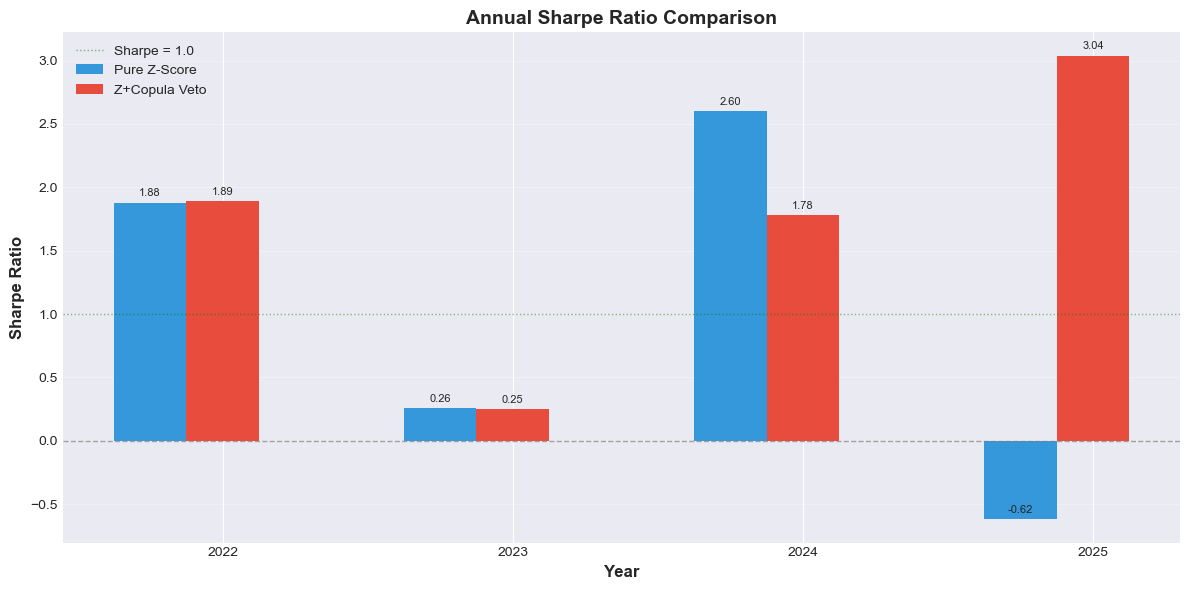

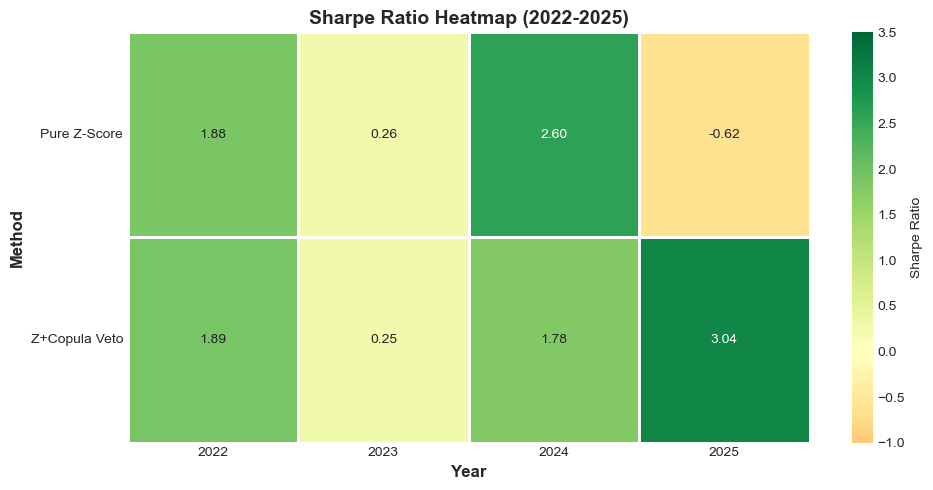

In [ ]:
# Annual Sharpe Comparison (Bar Chart)
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(years))
width = 0.25

bars1 = ax.bar(x - width, summary['PZ Sharpe'], width, label='Pure Z-Score', color='#3498db')
bars2 = ax.bar(x, summary['ZCV Sharpe'], width, label='Z+Copula Veto', color='#e74c3c')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax.set_title('Annual Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.axhline(y=1.0, color='green', linestyle=':', linewidth=1, alpha=0.5, label='Sharpe = 1.0')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(Path(BACKTEST_DIR + '/annual_sharpe_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Performance Heatmap
fig, ax = plt.subplots(figsize=(10, 5))

heatmap_data = summary[['PZ Sharpe', 'ZCV Sharpe']].T
heatmap_data.columns = years

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            linewidths=2, cbar_kws={'label': 'Sharpe Ratio'},
            vmin=-1, vmax=3.5)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Method', fontsize=12, fontweight='bold')
ax.set_title('Sharpe Ratio Heatmap (2022-2025)', fontsize=14, fontweight='bold')
ax.set_yticklabels(['Pure Z-Score', 'Z+Copula Veto'], rotation=0)

plt.tight_layout()
plt.savefig(Path(BACKTEST_DIR + '/sharpe_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

### **2025 - The Divergence: Risk Mitigation Benefit of Copula Veto**


THE 2025 REGIME BREAK - CRITICAL ANALYSIS


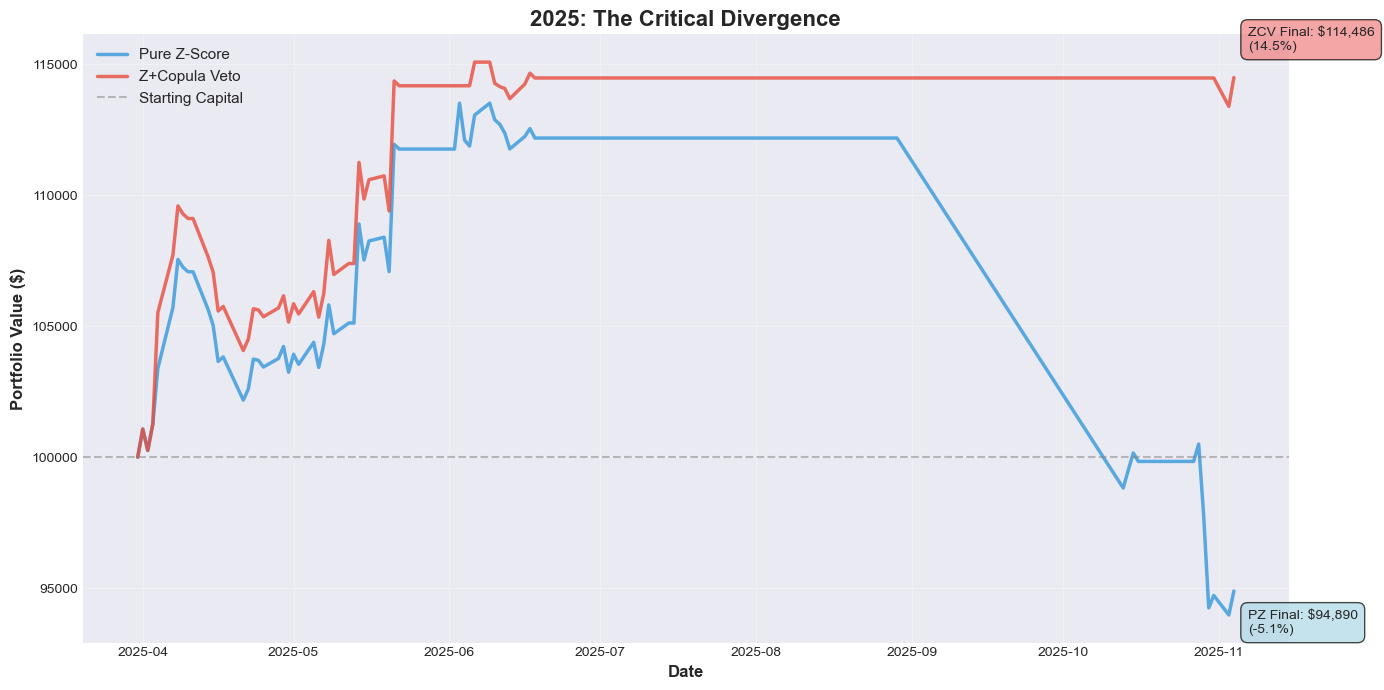


2025 PERFORMANCE BREAKDOWN:
--------------------------------------------------------------------------------
      Metric Pure Z-Score Z+Copula Veto
Sharpe Ratio        -0.62          3.04
Total Return       -5.11%        14.49%
Max Drawdown      -17.21%        -5.03%
    Win Rate        50.0%         51.1%


In [ ]:
# Load 2025 portfolios
pz_2025 = portfolio_data.get((2025, 'Pure Z-Score'))
zcv_2025 = portfolio_data.get((2025, 'Z+Copula Veto'))

if pz_2025 is not None and zcv_2025 is not None:
    
    # Side-by-side equity curves
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(pz_2025.index, pz_2025['equity_curve'], 
            label='Pure Z-Score', linewidth=2.5, color='#3498db', alpha=0.8)
    ax.plot(zcv_2025.index, zcv_2025['equity_curve'], 
            label='Z+Copula Veto', linewidth=2.5, color='#e74c3c', alpha=0.8)
    
    ax.axhline(y=100000, color='gray', linestyle='--', linewidth=1.5, 
               alpha=0.5, label='Starting Capital')
    
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
    ax.set_title('2025: The Critical Divergence', fontsize=16, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add annotations for final values
    pz_final = pz_2025['equity_curve'].iloc[-1]
    zcv_final = zcv_2025['equity_curve'].iloc[-1]
    
    ax.annotate(f'PZ Final: ${pz_final:,.0f}\n({(pz_final/100000-1)*100:.1f}%)',
                xy=(pz_2025.index[-1], pz_final),
                xytext=(10, -30), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7),
                fontsize=10, ha='left')
    
    ax.annotate(f'ZCV Final: ${zcv_final:,.0f}\n({(zcv_final/100000-1)*100:.1f}%)',
                xy=(zcv_2025.index[-1], zcv_final),
                xytext=(10, 20), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.7),
                fontsize=10, ha='left')
    
    plt.tight_layout()
    plt.savefig(Path(BACKTEST_DIR + '/2025_divergence.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Performance comparison
    print("\n2025 PERFORMANCE BREAKDOWN:")
    print("-" * 80)
    
    pz_metrics = metrics_data.get((2025, 'Pure Z-Score'))
    zcv_metrics = metrics_data.get((2025, 'Z+Copula Veto'))
    
    comparison = pd.DataFrame({
        'Metric': ['Sharpe Ratio', 'Total Return', 'Max Drawdown', 'Win Rate'],
        'Pure Z-Score': [
            pz_metrics.loc[0, 'Sharpe Ratio'],
            pz_metrics.loc[0, 'Total Return'],
            pz_metrics.loc[0, 'Maximum Drawdown'],
            pz_metrics.loc[0, 'Win Rate (Daily)']
        ],
        'Z+Copula Veto': [
            zcv_metrics.loc[0, 'Sharpe Ratio'],
            zcv_metrics.loc[0, 'Total Return'],
            zcv_metrics.loc[0, 'Maximum Drawdown'],
            zcv_metrics.loc[0, 'Win Rate (Daily)']
        ]
    })
    
    print(comparison.to_string(index=False))
    
else:
    print("⚠ 2025 data not found")

Without copula protection, a simple z score strategy would have lost money in 2025 with a sharpe of -0.62. However, with copula veto, strategy achieved 3.04 Sharpe +14.49% return. This proves copulas provide essential regime-break protection"

### **Equity Curve Analysis**

In [55]:
# Combining all years into continuous equity curves
def build_continuous_equity(years, method_name):

    equity_curve = pd.Series(dtype=float)
    cumulative_capital = 100000
    
    for year in years:
        if (year, method_name) in portfolio_data:
            year_portfolio = portfolio_data[(year, method_name)]
            
            # Normalizing to start at current cumulative capital
            year_equity = year_portfolio['equity_curve'].copy()
            year_return = year_equity / year_equity.iloc[0]  # Normalize to 1
            year_equity_scaled = cumulative_capital * year_return
            
            equity_curve = pd.concat([equity_curve, year_equity_scaled])
            
            # Update cumulative capital for next year
            cumulative_capital = year_equity_scaled.iloc[-1]
    
    return equity_curve

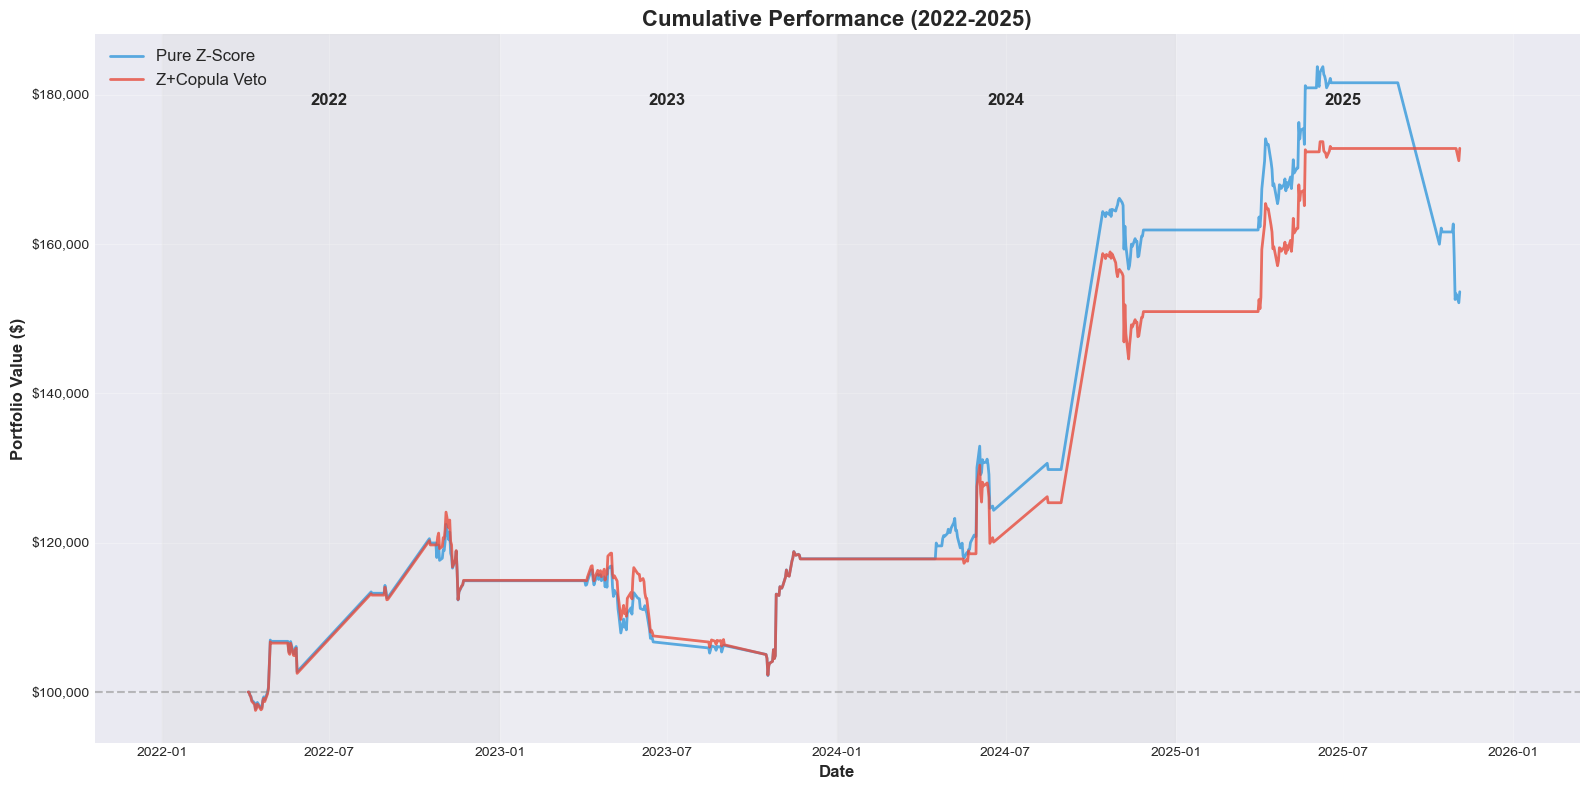


FINAL PORTFOLIO VALUES (After 4 years):
  Pure Z-Score:     $153,601 (+53.6%)
  Z+Copula Veto:    $172,808 (+72.8%)


In [ ]:
# Build curves
pz_equity = build_continuous_equity(years, 'Pure Z-Score')
zcv_equity = build_continuous_equity(years, 'Z+Copula Veto')

# Plot
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(pz_equity.index, pz_equity.values, 
        label='Pure Z-Score', linewidth=2, color='#3498db', alpha=0.8)
ax.plot(zcv_equity.index, zcv_equity.values, 
        label='Z+Copula Veto', linewidth=2, color='#e74c3c', alpha=0.8)

# Shade years
year_colors = ['lightgray', 'whitesmoke', 'lightgray', 'whitesmoke']
for i, year in enumerate(years):
    year_start = pd.to_datetime(f'{year}-01-01')
    year_end = pd.to_datetime(f'{year}-12-31')
    ax.axvspan(year_start, year_end, alpha=0.2, color=year_colors[i])
    ax.text(year_start + pd.DateOffset(months=6), ax.get_ylim()[1] * 0.95, 
            str(year), fontsize=12, ha='center', fontweight='bold')

ax.axhline(y=100000, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Performance (2022-2025)', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3)

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.savefig(Path(BACKTEST_DIR + '/cumulative_equity.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print final values
print(f"\nFINAL PORTFOLIO VALUES (After 4 years):")
print(f"  Pure Z-Score:     ${pz_equity.iloc[-1]:,.0f} ({(pz_equity.iloc[-1]/100000-1)*100:+.1f}%)")
print(f"  Z+Copula Veto:    ${zcv_equity.iloc[-1]:,.0f} ({(zcv_equity.iloc[-1]/100000-1)*100:+.1f}%)")

### **Drawdown Analysis**

In [54]:
def calculate_drawdown(equity_series):
    """Calculate drawdown series"""
    running_max = equity_series.expanding().max()
    drawdown = (equity_series - running_max) / running_max * 100
    return drawdown

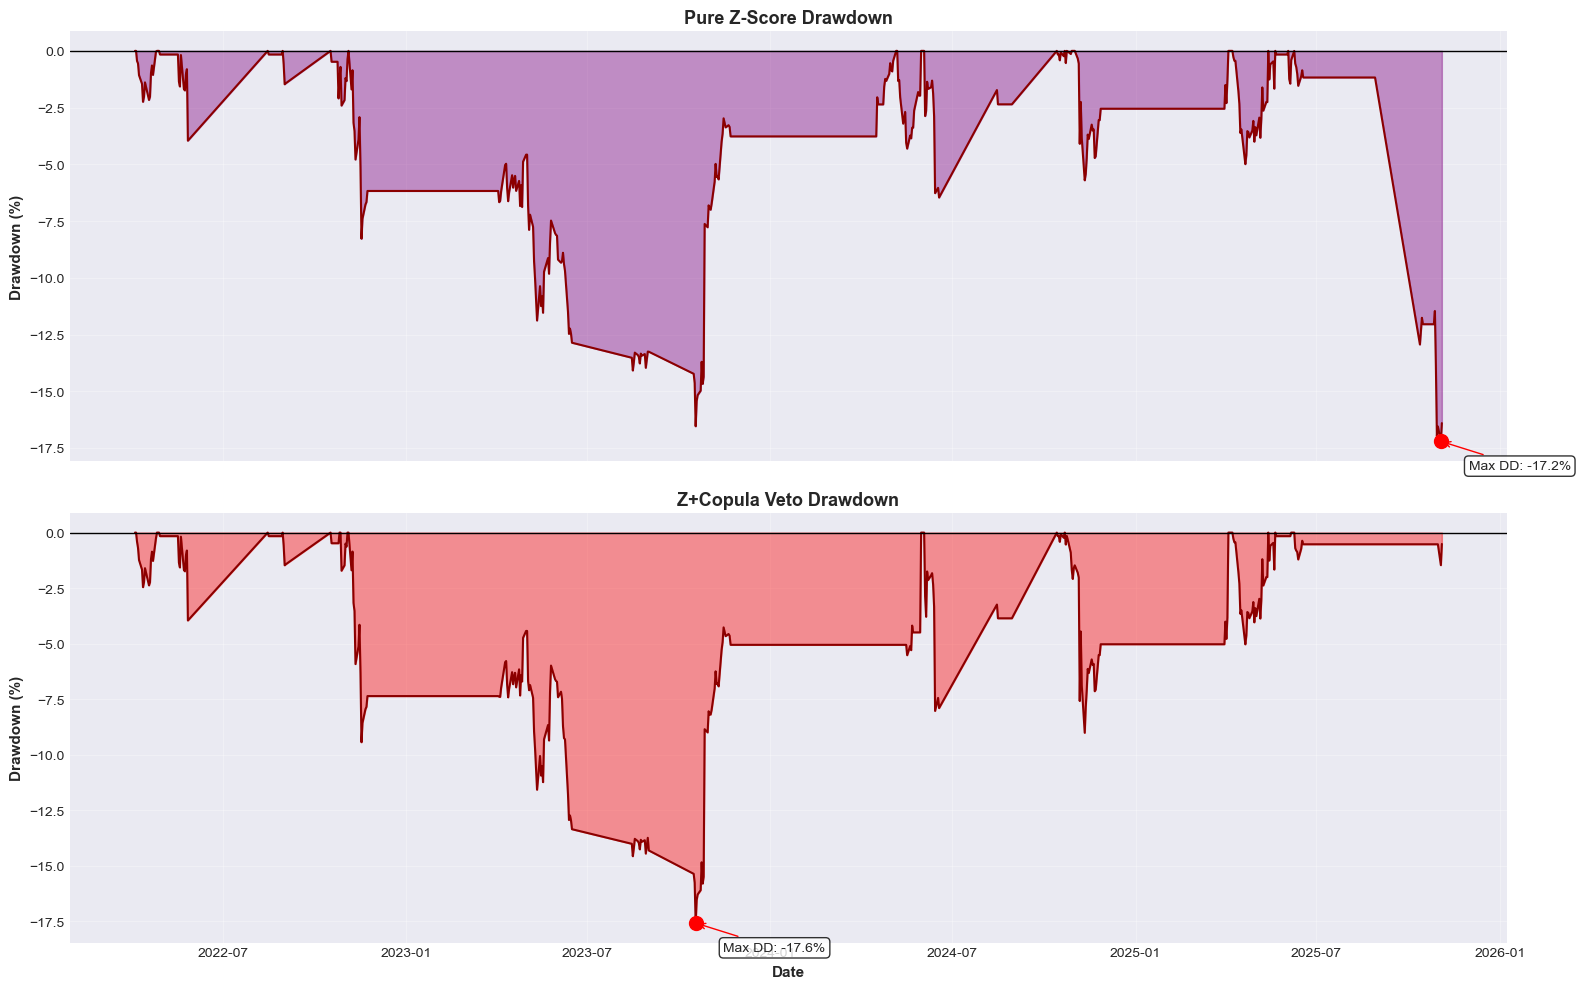

In [ ]:
# Underwater plots
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# PZ
dd_pz = calculate_drawdown(pz_equity)
axes[0].fill_between(dd_pz.index, dd_pz, 0, alpha=0.4, color='purple')
axes[0].plot(dd_pz, color='darkred', linewidth=1.5)
axes[0].set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Pure Z-Score Drawdown', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='black', linewidth=1)

# Mark max drawdown
max_dd_idx = dd_pz.idxmin()
max_dd_val = dd_pz.min()
axes[0].scatter([max_dd_idx], [max_dd_val], color='red', s=100, zorder=5)
axes[0].annotate(f'Max DD: {max_dd_val:.1f}%',
                xy=(max_dd_idx, max_dd_val),
                xytext=(20, -20), textcoords='offset points',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='red'))

# ZCV
dd_zcv = calculate_drawdown(zcv_equity)
axes[1].fill_between(dd_zcv.index, dd_zcv, 0, alpha=0.4, color='red')
axes[1].plot(dd_zcv, color='darkred', linewidth=1.5)
axes[1].set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[1].set_title('Z+Copula Veto Drawdown', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linewidth=1)

# Mark max drawdown
max_dd_idx = dd_zcv.idxmin()
max_dd_val = dd_zcv.min()
axes[1].scatter([max_dd_idx], [max_dd_val], color='red', s=100, zorder=5)
axes[1].annotate(f'Max DD: {max_dd_val:.1f}%',
                xy=(max_dd_idx, max_dd_val),
                xytext=(20, -20), textcoords='offset points',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.savefig(Path(BACKTEST_DIR + '/drawdown_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

### **Rolling Performance Metrics**

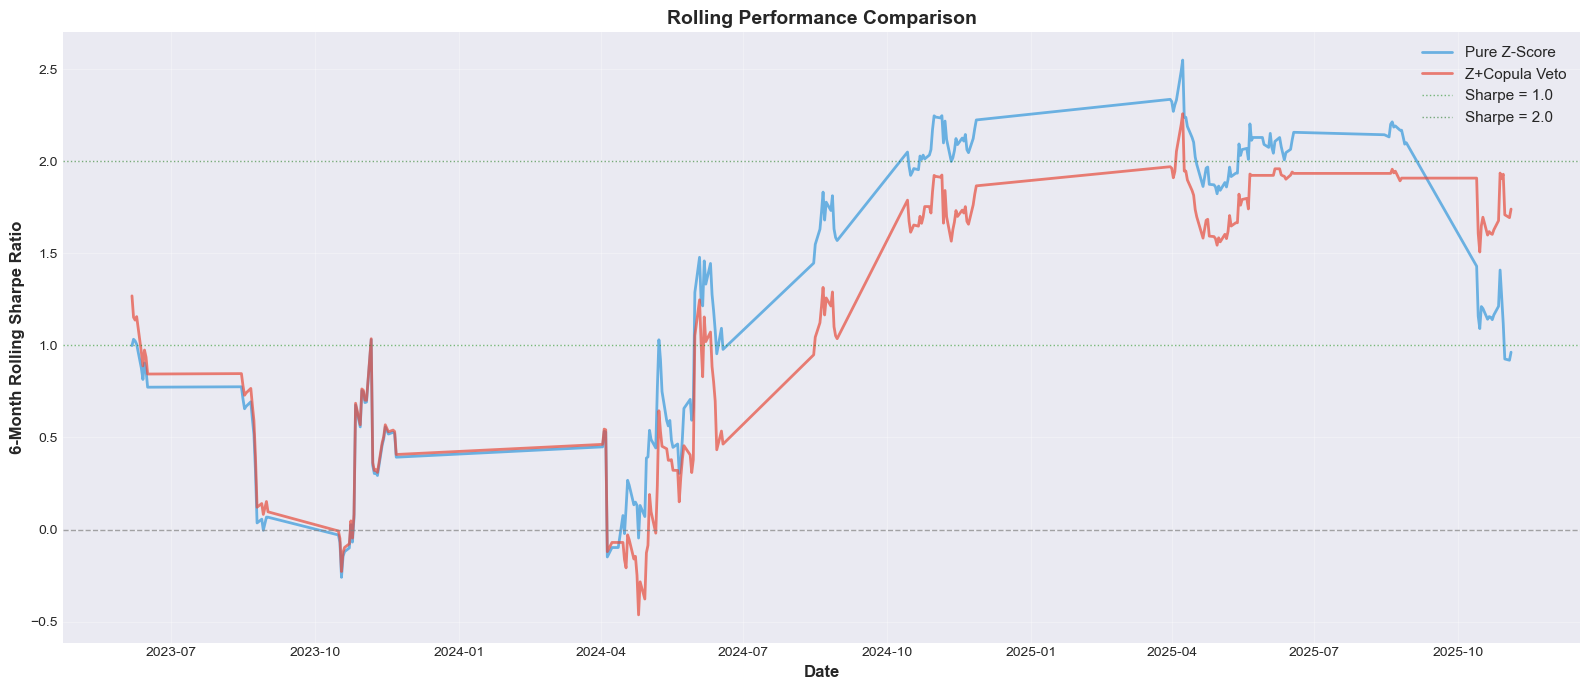


ROLLING SHARPE STATISTICS:
  Pure Z-Score:
    Mean: 1.29
    Std Dev: 0.80
    Min: -0.26
    Max: 2.55

  Z+Copula Veto:
    Mean: 1.13
    Std Dev: 0.74
    Min: -0.46
    Max: 2.26


In [51]:
# 6.1 Rolling Sharpe Ratio (6-month window)
def rolling_sharpe(returns, window=126):  # ~6 months
    """Calculate rolling Sharpe ratio"""
    return returns.rolling(window).apply(
        lambda x: (np.mean(x) / np.std(x) * np.sqrt(252)) if np.std(x) > 0 else 0
    )

# Calculate daily returns
pz_returns = pz_equity.pct_change().dropna()
zcv_returns = zcv_equity.pct_change().dropna()

# Rolling Sharpe
pz_rolling = rolling_sharpe(pz_returns)
zcv_rolling = rolling_sharpe(zcv_returns)

# Plot
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(pz_rolling.index, pz_rolling.values, 
        label='Pure Z-Score', linewidth=2, color='#3498db', alpha=0.7)
ax.plot(zcv_rolling.index, zcv_rolling.values, 
        label='Z+Copula Veto', linewidth=2, color='#e74c3c', alpha=0.7)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.axhline(y=1, color='green', linestyle=':', linewidth=1, alpha=0.5, label='Sharpe = 1.0')
ax.axhline(y=2, color='darkgreen', linestyle=':', linewidth=1, alpha=0.5, label='Sharpe = 2.0')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('6-Month Rolling Sharpe Ratio', fontsize=12, fontweight='bold')
ax.set_title('Rolling Performance Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path(BACKTEST_DIR + '/rolling_sharpe.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nROLLING SHARPE STATISTICS:")
print(f"  Pure Z-Score:")
print(f"    Mean: {pz_rolling.mean():.2f}")
print(f"    Std Dev: {pz_rolling.std():.2f}")
print(f"    Min: {pz_rolling.min():.2f}")
print(f"    Max: {pz_rolling.max():.2f}")
print(f"\n  Z+Copula Veto:")
print(f"    Mean: {zcv_rolling.mean():.2f}")
print(f"    Std Dev: {zcv_rolling.std():.2f}")
print(f"    Min: {zcv_rolling.min():.2f}")
print(f"    Max: {zcv_rolling.max():.2f}")

### **Year Deep Dive**

In [56]:
# Create detailed year-by-year comparison
print("\n" + "="*100)
print("YEAR-BY-YEAR DETAILED ANALYSIS")
print("="*100)

for year in years:
    print(f"\n{'─'*100}")
    print(f"YEAR {year}")
    print(f"{'─'*100}")
    
    # Get data for both methods
    pz_data = portfolio_data.get((year, 'Pure Z-Score'))
    zcv_data = portfolio_data.get((year, 'Z+Copula Veto'))
    
    if pz_data is None or zcv_data is None:
        print("  ⚠ Data not available")
        continue
    
    # Calculate statistics
    pz_trades = (pz_data['active_positions'] > 0).sum()
    zcv_trades = (zcv_data['active_positions'] > 0).sum()
    
    pz_final_value = pz_data['equity_curve'].iloc[-1]
    zcv_final_value = zcv_data['equity_curve'].iloc[-1]
    
    pz_return = (pz_final_value / pz_data['equity_curve'].iloc[0] - 1) * 100
    zcv_return = (zcv_final_value / zcv_data['equity_curve'].iloc[0] - 1) * 100
    
    print(f"\nPure Z-Score:")
    print(f"Return: {pz_return:+.2f}%")
    print(f"Trading Days: {pz_trades}")
    print(f"Final Value: ${pz_final_value:,.0f}")
    
    print(f"\nZ+Copula Veto:")
    print(f"Return: {zcv_return:+.2f}%")
    print(f"Trading Days: {zcv_trades}")
    print(f"Final Value: ${zcv_final_value:,.0f}")
    
    print(f"\nDifference:")
    print(f"Return Delta: {zcv_return - pz_return:+.2f}%")
    print(f"Trading Days Delta: {zcv_trades - pz_trades:+d}")
    
    # Interpretation
    if year == 2025:
        print(f"\nCRITICAL YEAR: Copula saved the strategy from losses")
    elif abs(pz_return - zcv_return) < 1:
        print(f"\nBoth methods performed similarly")
    elif pz_return > zcv_return:
        print(f"\nPure Z-Score outperformed (strong mean reversion regime)")
    else:
        print(f"\nCopula veto outperformed (regime protection activated)")


YEAR-BY-YEAR DETAILED ANALYSIS

────────────────────────────────────────────────────────────────────────────────────────────────────
YEAR 2022
────────────────────────────────────────────────────────────────────────────────────────────────────

Pure Z-Score:
Return: +14.90%
Trading Days: 82
Final Value: $114,900

Z+Copula Veto:
Return: +14.95%
Trading Days: 82
Final Value: $114,954

Difference:
Return Delta: +0.05%
Trading Days Delta: +0

Both methods performed similarly

────────────────────────────────────────────────────────────────────────────────────────────────────
YEAR 2023
────────────────────────────────────────────────────────────────────────────────────────────────────

Pure Z-Score:
Return: +2.56%
Trading Days: 95
Final Value: $102,562

Z+Copula Veto:
Return: +2.49%
Trading Days: 95
Final Value: $102,492

Difference:
Return Delta: -0.07%
Trading Days Delta: +0

Both methods performed similarly

───────────────────────────────────────────────────────────────────────────────